In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.pipelines.pipeline_utils import load_pipeline
import torch
from text3d2video.pipelines.controlnet_pipeline import BaseControlNetPipeline

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
device = 'cuda'
pipe = load_pipeline(BaseControlNetPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


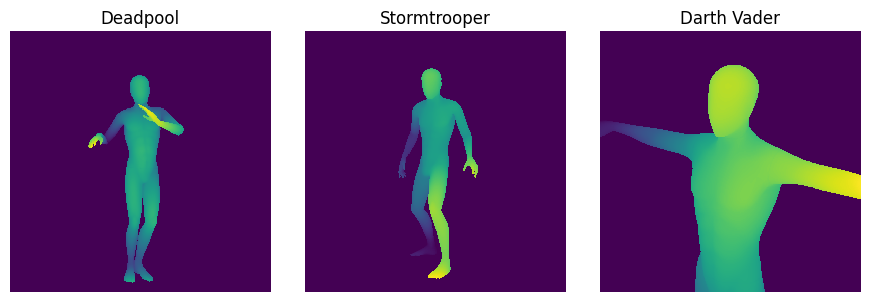

In [15]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

from text3d2video.rendering import render_depth_map
from text3d2video.utilities.ipython_utils import display_ims

prompts = []
depths = []


def render_depth(anim_tag: str, frame_index: int):
    anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
    cam, mesh = anim.load_frames(frame_index)
    depth = render_depth_map(mesh, cam)[0]
    return depth


def add_entry(anim_tag, frame_index, prompt):
    depth = render_depth(anim_tag, frame_index)
    depths.append(depth)
    prompts.append(prompt)


add_entry("rumba:latest", 0, "Deadpool")
add_entry("backflip:latest", 0, "Stormtrooper")
add_entry("mv_human_zoom_head:latest", 1, "Darth Vader")
# add_entry("booty:latest", 60, "Abraham Lincoln")
# add_entry("joyful_jump:latest", 30, "George Washington")
# add_entry("mv_cat_statue:latest", -1, "Tabby Cat")

display_ims(depths, titles=prompts)

In [16]:
seed = 1

gen = torch.Generator(device=device)
gen.manual_seed(seed)

images = pipe(
    prompts,
    depths,
    generator=gen,
    num_inference_steps=30,
    controlnet_conditioning_scale=1,
    guidance_scale=7.5,
)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:03<00:00,  7.70it/s]


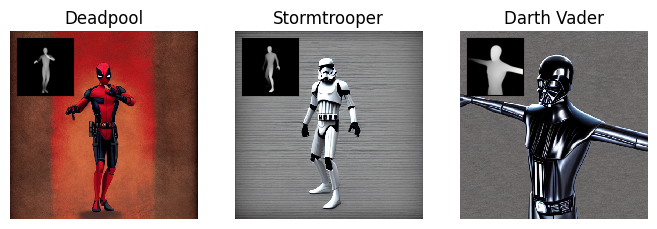

In [17]:
from matplotlib import pyplot as plt
from text3d2video.utilities.matplotlib_utils import add_inset


fig, axs = display_ims(images, titles=prompts, show=False, scale=2.3)

for i, ax in enumerate(axs):
    axins = add_inset(ax, loc='upper left', width="30%")
    axins.imshow(depths[i], cmap='gray')

plt.savefig("outs/depth2img.pdf", dpi=300, bbox_inches='tight')